# Model Preprocessing
---
This notebook performs the necessary preprocessing of CanRCM4 models. Execute each cell in order.

* Place netCDF models into `climpyrical/data/model_inputs`. 
* Ensure ensemble models have:
    * lat, lon, rlat, rlon and a 2D data field variable
    
Output directories are configurable, but are recommended to be placed in `climpyrical/data/results/intermediate/preprocessed_netcdf/`

Workflow:

<img src="../../docs/assets/flowchart_model.png" alt="flowchart" width="450"/>

In [1]:
from climpyrical.data import read_data, gen_dataset, interpolate_dataset
from climpyrical.gridding import regrid_ensemble, extend_north

from pkg_resources import resource_filename
import warnings

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext lab_black

### Parameters are loaded from config_example.yml
Example configuration from config_example.yml:
```
    paths:
        preprocessed_model_path: /data/results/intermediate/preprocessed_netcdf/
    RL50:
        station_dv: "RL50 (kPa)"
        station_path: 'data/station_inputs/Interim_snow_rain_load_LR_composite_stations_tbd_v4.csv'
        input_model_path: 'data/model_inputs/snw_rain_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc'
        medians: 
            value: 0.4
            action: "multiply"
        fill_glaciers: True
```

In [2]:
# Parameters cell

In [3]:
# Parameters
name = "RHann"
station_dv = "mean RH (%)"
station_path = "data/station_inputs/rh_annual_mean_10yr_for_maps.csv"
input_model_path = "data/model_inputs/hurs_CanRCM4-LE_ens15_1951-2016_ensmean.nc"
medians = {"value": "None", "action": "None"}
fill_glaciers = True
output_notebook_path = "/data/results/intermediate/notebooks/"
preprocessed_model_path = "/data/results/intermediate/preprocessed_netcdf/"
preprocessed_stations_path = "/data/results/intermediate/preprocessed_stations/"
output_reconstruction_path = "/data/results/netcdf/"
output_tables_path = "/data/results/TableC2/"
output_figure_path = "/data/results/figures/"
mask_path = "data/masks/canada_mask_rp.nc"
north_mask_path = "data/masks/canada_mask_north_rp.nc"
nbcc_loc_path = "data/station_inputs/NBCC_2020_new_coords.xlsm"


Load the CanRCM4 model at native resolution

In [4]:
ds = read_data(resource_filename("climpyrical", input_model_path))
(dv,) = ds.data_vars
unit = ds[dv].attrs["units"]
print(f"Design value header name: {dv}")
print(f"Units in model file: {unit}")

Design value header name: hurs
Units in model file: %


After loading, check for accepted units and convert `degC` to `K` if necessary

In [5]:
rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)
mean = ds[dv].values

accepted_units = ["kPa", "kPas", "Pas" "Pa", "degC", "degC-day", "mm", "unitless", "%"]

print(f"Detect units: {unit}")
if unit not in accepted_units:
    warnings.warn(
        f"{unit} not recognized from list of accepted units: {accepted_units}"
    )

# For temperature fields, the methodology prefers
# if units are in degress K
# if unit == "degC":
#     kelvin = 273.15  # K
#     print("Temperature field detected. Converting to Kelvin.")
#     mean += kelvin
#     ds[dv].attrs["units"] = "K"    
#     unit = ds[dv].attrs["units"]

print(f"Units in model file: {unit}")

Detect units: %
Units in model file: %


Load the masks, starting with the land mask at the native CanRCM4 resolution and the glacier mask

In [6]:
path_mask = resource_filename("climpyrical", "data/masks/land_mask_CanRCM4_sftlf.nc")
path_glacier_mask = resource_filename("climpyrical", "data/masks/glacier_mask.nc")

print("Load and regrid file to target resolution")

mask = read_data(path_mask)
mask = regrid_ensemble(mask, "sftlf", 10, copy=True)
mask = mask["sftlf"] >= 1.0

print("Load original reoslution mask for reference")
mask_og = read_data(path_mask)["sftlf"].values != 0.0
glaciermask = read_data(path_glacier_mask)["mask"].values != 0.0

Load and regrid file to target resolution


/home/nannau/Desktop/pipeline/pipevenv/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Load original reoslution mask for reference


plot masks as example

Text(0.5, 1.0, 'Glacier mask')

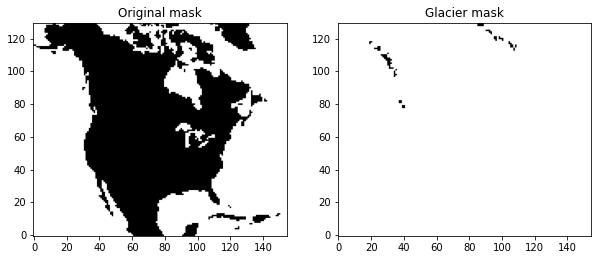

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(mask_og, origin="lower", cmap="Greys")
ax[0].set_title("Original mask")
ax[1].imshow(glaciermask, origin="lower", cmap="Greys")
ax[1].set_title("Glacier mask")

Perform bilinear interpolation over glacier points if required

In [8]:
if fill_glaciers:
    print("Filling spurious glacier points.")
    mean[glaciermask] = np.nan

nanmask = ~np.isnan(mean)
points = np.stack([rlon[nanmask], rlat[nanmask]]).T
target_values = mean[nanmask]
target_points = np.stack([rlon[glaciermask], rlat[glaciermask]]).T

mean[glaciermask] = interpolate_dataset(
    points, target_values, target_points, "linear"
)

ds_filled = gen_dataset(dv, mean, ds.rlat, ds.rlon, ds.lat, ds.lon, unit)


Filling spurious glacier points.


In [9]:
print("Remove water cells at original resolution")
ds_filled[dv].values[~mask_og] = np.nan
nanmask = ~np.isnan(ds_filled[dv].values)

Remove water cells at original resolution


In [10]:
print("Copying and downscaling dataset 10x")
ds10 = regrid_ensemble(ds_filled, dv, 10, copy=True)
ds10[dv].values[~mask] = np.nan
nrlon, nrlat = np.meshgrid(ds10.rlon, ds10.rlat)
nanmask10 = ~np.isnan(ds10[dv].values)

Copying and downscaling dataset 10x


/home/nannau/Desktop/pipeline/pipevenv/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [11]:
print("Interpolating full remaining grid")
points = np.stack([rlon[nanmask], rlat[nanmask]]).T
target_points = np.stack([nrlon[nanmask10], nrlat[nanmask10]]).T
values = ds[dv].values[nanmask]
ds10[dv].values[nanmask10] = interpolate_dataset(
    points, values, target_points, "linear"
)

Interpolating full remaining grid


In [12]:
print("Add northern domain to model")
ds10 = extend_north(ds10, dv, 210, fill_val=np.nan)
nanmask10 = ~np.isnan(ds10[dv].values)

Add northern domain to model


/home/nannau/Desktop/pipeline/pipevenv/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Load the higher resolution canada mask

Text(0.5, 1.0, 'Missing points mask')

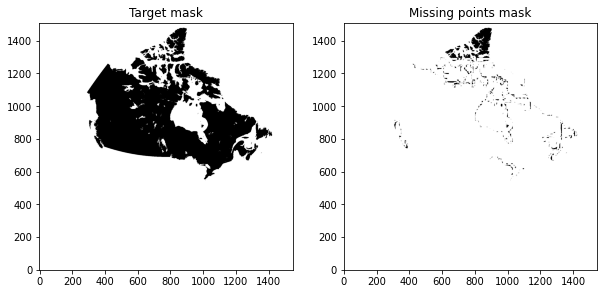

In [13]:
canada_mask_path = resource_filename("climpyrical", "/data/masks/canada_mask_rp.nc")
with read_data(canada_mask_path) as ds_canada:
    ca_mask = ds_canada["mask"].values

# select NaN values within new mask
ca_mask_or = ~np.logical_or(~ca_mask, nanmask10)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(ca_mask, origin="lower", cmap="Greys")
ax[0].set_title("Target mask")
ax[1].imshow(ca_mask_or, origin="lower", cmap="Greys")
ax[1].set_title("Missing points mask")

In [14]:
print("Fill remaining missing points using closest neighbour.")
nrlon, nrlat = np.meshgrid(ds10.rlon.values, ds10.rlat.values)

temp_field = ds10[dv].values

points = np.stack([nrlon[nanmask10], nrlat[nanmask10]]).T
target_points = np.stack([nrlon[ca_mask_or], nrlat[ca_mask_or]]).T
target_values = ds10[dv].values[nanmask10]
temp_field[~ca_mask] = np.nan

temp_field[ca_mask_or] = interpolate_dataset(
    points, target_values, target_points, "nearest"
)

Fill remaining missing points using closest neighbour.


In [15]:
print("Remove the processed northern region.")
uaa_mask_path = resource_filename(
    "climpyrical", "/data/masks/canada_mask_north_rp.nc"
)
uaa_mask = read_data(uaa_mask_path)["mask"]
temp_field[uaa_mask] = np.nan

ds_processed = gen_dataset(
    dv, temp_field, ds10.rlat, ds10.rlon, ds10.lat, ds10.lon, unit
)
# Populate new processed dataset with attributes from 
# the original
if ds.attrs:
    all_keys = set(ds_processed.variables).union(set(ds_processed.dims))
    for key in all_keys:
        ds_processed[key].attrs = ds[key].attrs
    attr_dict = ds.attrs
    attr_dict["Climpyrical"] = (
        "CanRCM4 Reconstruction contains"
        "hybrid station and model data using"
        "Climpyrical (https://github.com/pacificclimate/climpyrical)"
    )

    ds_processed.attrs = attr_dict

print("Dataset generated and writing to file.")

ds_processed.to_netcdf(resource_filename("climpyrical", f"{preprocessed_model_path}{name}.nc"), mode="w")

print("Completed!")

Remove the processed northern region.
Dataset generated and writing to file.


Completed!


Plot the final result

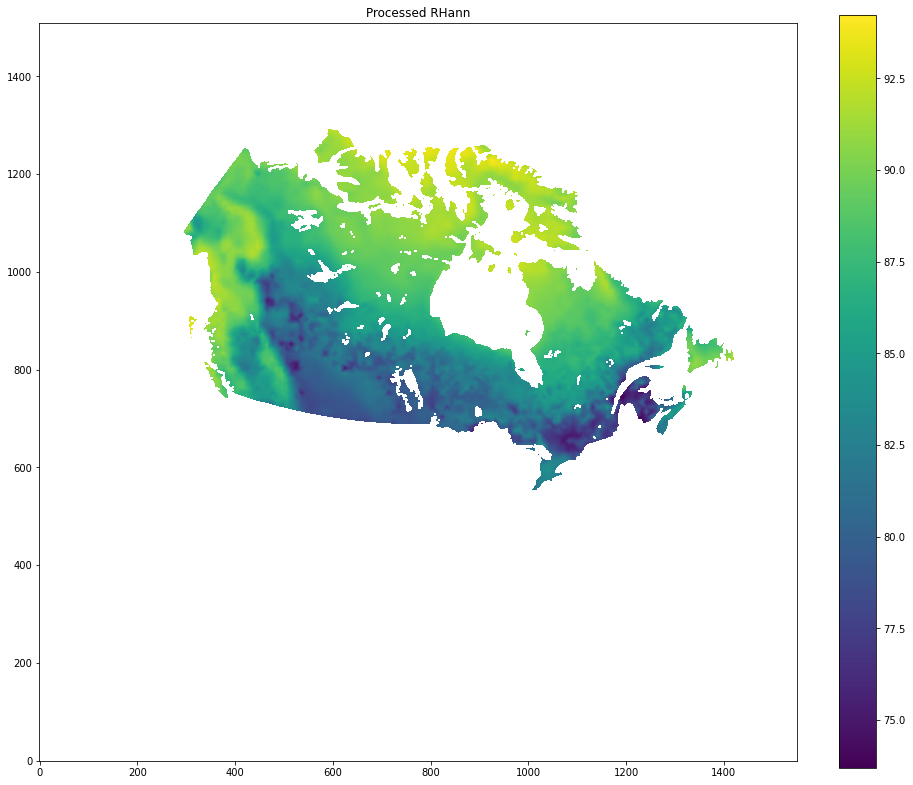

In [16]:
plt.figure(figsize=(15, 15))
plt.title(f"Processed {name}")
plt.imshow(ds_processed[dv].values, origin="lower")
plt.colorbar(fraction=0.045)